In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pickle
from IPython.core.display import display, HTML

import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('spectrograms_segmented.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 693


In [4]:
x_list = [specgram.shape[1] for specgram in specgrams]
min_x = min(x_list)
max_x = max(x_list)
print(min_x, max_x)

10 72


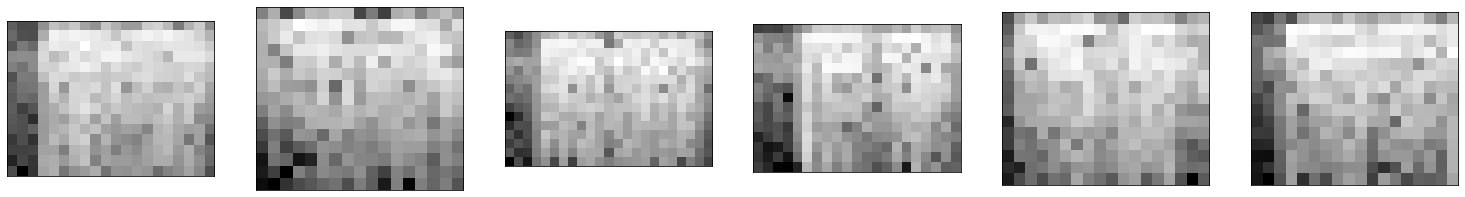

In [5]:
n=6
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(specgrams[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [6]:
print(len(specgrams))
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:,:min_x])
    if len(specgram[1]) > min_x:
        reshape.append(specgram[:,-min_x:])

print(len(reshape))

693
1384


In [7]:
dim = reshape[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(15, 10, 1)


In [8]:
X_train, X_test = train_test_split(reshape, test_size=0.25, shuffle=False)
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))
print('Training samples: %s' % len(X_train))
print('Test samples: %s' % len(X_test))

Training samples: 1038
Test samples: 346


## Autoencoder Model

In [9]:
input_img = Input(shape=dim)

# encoder
## conv.layers
code = Conv2D(8, kernel_size=(6,6), activation='relu')(input_img)
# code = MaxPooling2D(pool_size=(2, 2))(code)
# code = Conv2D(8, kernel_size=(3,2), padding='valid', activation='relu')(code)
code = MaxPooling2D(pool_size=(5, 5))(code)

## dense
code = Flatten()(code) # bottleneck
code = Dropout(0.25)(code)
code = Dense(8, activation='relu')(code)

# decoder
x_hat = Dense(16, activation='relu')(code)
x_hat = Reshape((2, 1, 8))(x_hat)
x_hat = UpSampling2D((5, 5))(x_hat)
# x_hat = Conv2DTranspose(8, kernel_size=(3,3), padding='valid', activation='relu')(x_hat)
#x_hat = UpSampling2D((2,2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(6,6), activation='relu')(x_hat)

#x_hat = Dense(784, activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 10, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 8)          296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 1, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
__________

In [10]:
# input_img = Input(X_train[0].shape)

# # encoder
# code = Dense(102, activation='relu')(input_img)
# code = Dense(34, activation='relu')(code)

# # decoder
# x_hat = Dense(102, activation='relu')(code)
# x_hat = Dense(306, activation='sigmoid')(x_hat)

# autoencoder = Model(input_img, x_hat)
# autoencoder.summary()

In [11]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')

# tamanho do batch por iteracao
batch_size = 10

# número de épocas 
epochs = 10

# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = autoencoder.fit([X_train], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1,
                    validation_data=([X_test], [X_test]))

Train on 1038 samples, validate on 346 samples
Epoch 1/10
1038/1038 [==============================] - 0s 393us/step - loss: 0.0821 - val_loss: 0.0337
Epoch 2/10
1038/1038 [==============================] - 0s 207us/step - loss: 0.0311 - val_loss: 0.0258
Epoch 3/10
1038/1038 [==============================] - 0s 206us/step - loss: 0.0267 - val_loss: 0.0296
Epoch 4/10
1038/1038 [==============================] - 0s 210us/step - loss: 0.0235 - val_loss: 0.0240
Epoch 5/10
1038/1038 [==============================] - 0s 202us/step - loss: 0.0225 - val_loss: 0.0272
Epoch 6/10
1038/1038 [==============================] - 0s 179us/step - loss: 0.0218 - val_loss: 0.0278
Epoch 7/10
1038/1038 [==============================] - 0s 180us/step - loss: 0.0218 - val_loss: 0.0217
Epoch 8/10
1038/1038 [==============================] - 0s 181us/step - loss: 0.0211 - val_loss: 0.0315
Epoch 9/10
1038/1038 [==============================] - 0s 182us/step - loss: 0.0209 - val_loss: 0.0232
Epoch 10/10
1038/

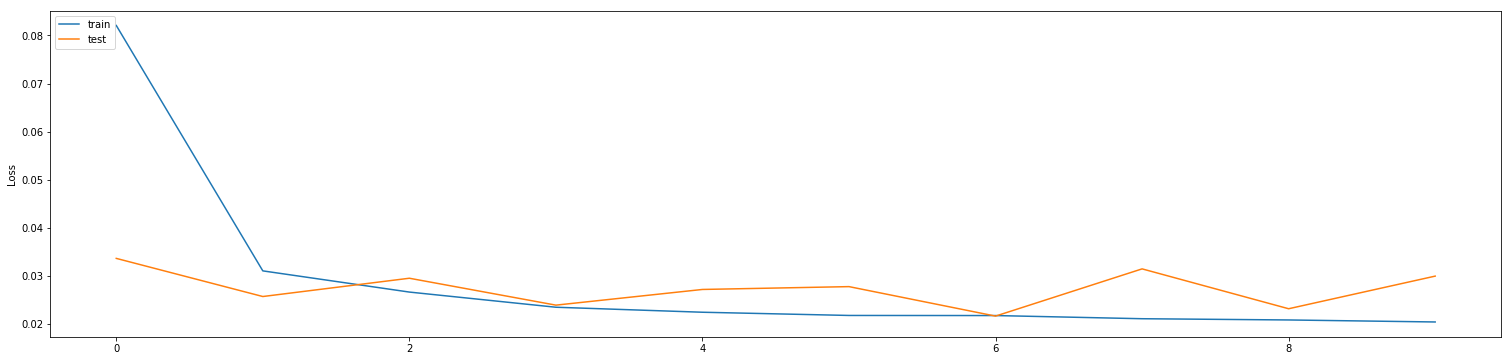

In [12]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

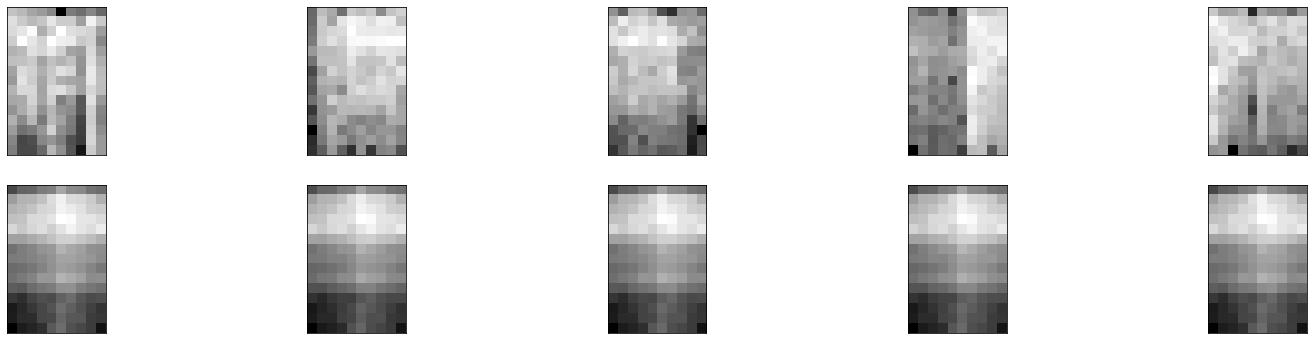

In [13]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

n=5
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(decoded_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_predictions[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()